**Buying a home in Corona times!**


The covid situation is becoming an unfortunate reality of our times. In these circumstances I often find people looking to buy stock or real estate, in the assumption that the market sentiment would be low and you may get a good deal. It was around March 2020 when I moved to Vilnius with my wife, the lockdown had just started. Was it a good time to buy the house in the coming months. It was time to find out.

**Every Hypothesis needs some data**

After wondering about the problem for a day or two, i was researching listings on the popular website skelbiu.lt. Tracking the real estate listings on the site can be a useful way of tracking the market. The average price of listings could give a fair indication as to where the market was heading.I checked the robots.txt on the site which allowed accessing the data just to be sure.

**The scrapy scraper**

I decided to use scrapy for building the scraper, mostly because of the flexibility. The house.py file below is part of the skelbiu scraper project in scrapy. The below code can not be run independently as part of the notebook and is given for illustration purpose.



import scrapy
from scrapy_splash import SplashRequest


class HouseSpider(scrapy.Spider):
    name = 'house'
    allowed_domains = ['www.skelbiu.lt'] 


    # the main function for splash which returns the html page, this function is called in the start_requests function
    script_start = '''
        function main(splash, args)
            
            splash:set_user_agent("Mozilla/5.0 (Windows NT 6.1; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/81.0.4044.92 Safari/537.36")
            url = args.url
            assert(splash:go(url))
            assert(splash:wait(8))
            
            splash:set_viewport_full()
            return splash:html()
        end

    '''
    
    # the below function calls the script_start function, the url returns the house entries in the vilnius district which is 
    # relevant district for the project
    def start_requests(self):
        yield SplashRequest(url="https://www.skelbiu.lt/skelbimai/?autocompleted=1&keywords=&submit_bn=&cost_min=&cost_max=&space_min=&space_max=&rooms_min=&rooms_max=&building_type=0&year_min=&year_max=&status=0&building=0&district=0&quarter=0&streets=0&ignorestreets=0&cities=465%2C466&distance=0&mainCity=1&search=1&category_id=42&type=0&user_type=0&ad_since_min=0&ad_since_max=0&visited_page=1&orderBy=-1&detailsSearch=1", callback=self.parse, endpoint="execute", args={
            'lua_source': self.script_start
        })

    # the below function parses the response which is html in this case. This html object needs to be parsed in the 
    # various columns of the database,especially the information field which contains multiple data fields bundled 
    # into one. The try ,except statements ensure that the script runs even if some data is 
    # missing
    
    def parse(self, response):
        print(response.body)
        for listing in response.xpath("//li[@class ='simpleAds' or @class = 'boldAds' ]"):
            url1 = listing.xpath(".//a/@href").get()
            information = listing.xpath(".//div[2]/div/div[2]/text()").getall()
            try:
                information1= information[0]
            except:
                information1 = 'None'
            
            try:
                information2= information[1]
            except:
                information2 = 'None'

            try:
                information3= information[2]
            except:
                information3 = 'None'

            try:
                information4= information[3]
            except:
                information4 = 'None'

            try:
                information5= information[4]
            except:
                information5 = 'None'


            
            yield {
               'ad_city': listing.xpath(".//div/div[1]/text()").get(),
               'ad_date': listing.xpath(".//div/div[2]/text()").get(),
               'url': f"https://www.skelbiu.lt{url1}",
               'heading':listing.xpath(".//div/h3/a/text()").get(),
               'address': listing.xpath(".//div[2]/div/div/text()").get(),  
              
               
               'information1': information1,
               'information2': information2,
               'information3': information3,
               'information4': information4,
               'information5': information5,
               'price': listing.xpath(".//div[2]/div[2]/span[1]/text()").get(),
               'pricepermeter': listing.xpath(".//div[2]/div[2]/span[2]/text()").get()

           }
    
        # the below line extracts the url for the next page from the response object
        next_page_rel_url = response.xpath("//a[@class ='pagination_link' and @rel = 'next' ]/@href").get()
        
        # the url obtained is only partial it needs to be joined with www.skelbiu.lt for the full url of the 
        # next page the below code line does that
        
        next_page_url = f"https://www.skelbiu.lt{next_page_rel_url}"
        
        # Till there is a next_page_rel_url the script_start is called with the new url and the process 
        repeats
        if next_page_rel_url != None:
            yield SplashRequest(url=next_page_url, callback=self.parse, endpoint="execute", args={
            'lua_source': self.script_start
        }) 

I ran the scraper on my local machine. Initially with the output in .csv format there was substantial data corruption. Tried the output in xml format, which worked. The xml data files are in the input/vilnius folder

**Xml to Dataframe**

Next step was extracting the xml file in a panda data frame. The data also has to be cleaned in a step by step manner.

In [50]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import xml.etree.ElementTree as etree

def xml_to_dataframe(path):
    tree = etree.parse(path)
    root = tree.getroot()
    column1 = []
    column2 = []
    column3 = []
    column4 = []
    column5 = []
    column6 = []
    column7 = []
    column8 = []
    column9 = []
    column10 = []
    column11 = []
    column12 = []

    counter = 0
    for root1 in root:
        for child in root1:
            if  child.tag == "ad_city":
                column1.append(child.text)
            if  child.tag == "ad_date":
                column2.append(child.text)
            if  child.tag == "url":
                column3.append(child.text)
            if  child.tag == "heading":
                column4.append(child.text)
            if  child.tag == "address":
                column5.append(child.text.replace(" ", ""))
            if  child.tag == "information1":
                column6.append(child.text)
            if  child.tag == "information2":
                if child.text != "None":
                    f = child.text.replace(",", ".")
                    column7.append(f.replace(" ", "")[:-1])

            if  child.tag == "information3":
                column8.append(child.text)
            if  child.tag == "information4":
                column9.append(child.text)
            if  child.tag == "information5":
                column10.append(child.text)
            if  child.tag == "price":
                if child.text != "None":
                    column11.append(child.text.replace(" ", "")[:-1])
            if  child.tag == "pricepermeter":
                if child.text != "None":
                    column12.append(child.text.replace(" ", "")[1:-5])

        counter+=1        

    column1 = pd.Series(column1, name='ad_city')           
    column2 = pd.Series(column2, name='ad_date')
    column3 = pd.Series(column3, name='url')  
    column4 = pd.Series(column4, name='heading')  
    column5 = pd.Series(column5, name='address')  
    column6 = pd.Series(column6, name='information1')  
    column7 = pd.Series(column7, name='information2(a)')  
    column8 = pd.Series(column8, name='information3')  
    column9 = pd.Series(column9, name='information4')  
    column10 = pd.Series(column10, name='information5')  
    column11 = pd.Series(column11, name='price(euro)' ,dtype = float)  
    column12 = pd.Series(column12, name='pricepermeter(euro/m2)' ,dtype = float)  

    df = pd.concat([column1, column2, column3, column4, column5, column6, column7, column8, column9, column10, column11, column12], axis=1)
    #print(df.shape)           
    #print(counter)
    #to check if all the columns have equal number of values 
    #print((len(column1)- counter) + (len(column1)- counter) + (len(column1)- counter) +(len(column1)- counter) +(len(column1)- counter) +(len(column1)- counter) +(len(column1)- counter) +(len(column1)- counter) +(len(column1)- counter) +(len(column1)- counter) +(len(column1)- counter) +(len(column1)- counter)  )
    df['housearea(m2)'] = column11/column12
    df_url = df['url']
    df_id1 = []
    for item in df_url:
        df_id1.append(item[-13:-5 ])

    df['id'] = pd.DataFrame(df_id1)
    df.dropna()

    # splitting the address column into three columns representing three parts of the address

    address_temp = df['address'].str.split(',', expand=True)
    address1 = pd.DataFrame(address_temp[0])
    address2 = pd.DataFrame(address_temp[1])
    address3 = pd.DataFrame(address_temp[2])

    df['address1'] = address1
    df['address2'] = address2
    df['address3'] = address3

    return df

date = ['16may', '28may', '4june', '11june', '18june', '25june', '2july', '9july', '15july', '23july']
path = f"../input/vilnius/{date[5]}.xml"

df = xml_to_dataframe(path)

**Cleaning the data **

In [51]:

def data_clean(df):
    #As can be seen some rows dont have price information, dropping the rows, that dont have price information.
    df = df.loc[df['price(euro)'].notnull()]
    #The address2 column will be used for analysis of region wise breakdown, some values are missing in this column, the below code replaces the null values with 'other'
    df.loc[df['address2'].isnull(), ['address2']] = 'other'
    return df

df = data_clean(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2148 entries, 0 to 2147
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ad_city                 2148 non-null   object 
 1   ad_date                 2148 non-null   object 
 2   url                     2148 non-null   object 
 3   heading                 2148 non-null   object 
 4   address                 2148 non-null   object 
 5   information1            2148 non-null   object 
 6   information2(a)         2148 non-null   object 
 7   information3            2148 non-null   object 
 8   information4            2148 non-null   object 
 9   information5            2148 non-null   object 
 10  price(euro)             2148 non-null   float64
 11  pricepermeter(euro/m2)  2148 non-null   float64
 12  housearea(m2)           2148 non-null   float64
 13  id                      2148 non-null   object 
 14  address1                2148 non-null   

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


The condition of the house is an important variable in determining the price. The information of this variable is given across two field in information3 and information4. the below code block creates a unified coloumn which gives the information required.

In [52]:
def add_condition_column(df):
    condition = []

    for i in range(len(df['information3'])):
        temp1 = df['information3'][i]
        if temp1[1:2].isnumeric():
            condition.append(df['information4'][i])

        else :
            condition.append(df['information3'][i])

    condition = pd.DataFrame(condition)
    df['condition'] = condition
    df["condition"] = df["condition"].astype('category')
    return df

df = add_condition_column(df)


The information of the plot size is given in information2(a), but some of the information is corrupted, lets change that into nan and and add a new coloumn name called plotsize. This is in aras.

In [53]:
def add_plotsize(df):
    
    plotsize = []
    count1 = 0
    count2 = 0

    for i in range(len(df['address'])):
        temp2 = df['information2(a)'][i]
        if temp2.replace('.','',1).isdigit() == True:
            plotsize.append(df['information2(a)'][i])
            count1+=1

        else :
            plotsize.append(np.nan)
            count2+=1
    plotsize = pd.DataFrame(plotsize)
    df['plotsize'] = plotsize
    print(count1, count2)
    df["plotsize"] = df["plotsize"].astype('float')
    
    return df

df = add_plotsize(df)

2141 7


In [54]:
#pd.set_option('display.max_rows', None)
#df[ 'plotsize']

Adding a regionprice column which gives the mean of the price in the region, the region information is captured by address2 column

In [55]:
def add_regionprice(df):
    add2 = df['address2']
    add3 = df['pricepermeter(euro/m2)']
    add2 = pd.Series(add2, name = 'address2', dtype = str)
    add3 = pd.Series(add3, name ='regionmeanprice', dtype = float )
    df1 = pd.concat([ add2, add3], axis = 1)
    regionprice = df1.groupby(['address2'], as_index = False).mean()
    regionprice = pd.DataFrame(regionprice)

    df = df.join(regionprice.set_index('address2'), on='address2')
    return df

df = add_regionprice(df)


**Data Visualisation**

Time to visualize the data, for starters lets see the price spread across the house area and the plotsize.

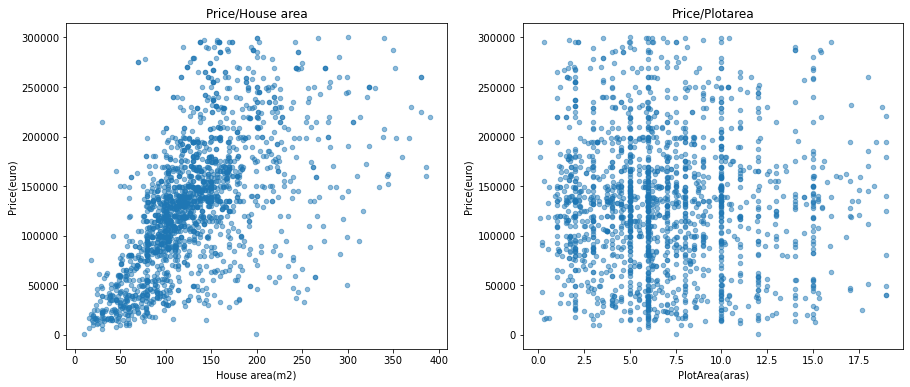

In [56]:
def plot1(df):    
    df1 = df.loc[df['price(euro)']<300000, ['housearea(m2)', 'price(euro)']]
    df2 = df1.loc[df['housearea(m2)']<400, ['housearea(m2)', 'price(euro)']]

    fig, ax = plt.subplots(1, 2,figsize=(15, 6))

    ax[0].set_xlabel('House area(m2)')  # Add an x-label to the axes.
    ax[0].set_ylabel('Price(euro)')  # Add a y-label to the axes.
    ax[0].set_title('Price/House area')
    scatter_plot = ax[0].scatter( df2['housearea(m2)'], df2['price(euro)'], s = 20, alpha = .5)
    
    df1 = df.loc[df['price(euro)']<300000, ['plotsize', 'price(euro)']]

    df2 = df1.loc[df1['plotsize'] < 20, ['plotsize', 'price(euro)']]
    

    ax[1].set_xlabel('PlotArea(aras)')  # Add an x-label to the axes.
    ax[1].set_ylabel('Price(euro)')  # Add a y-label to the axes.
    ax[1].set_title('Price/Plotarea')
    scatter_plot = ax[1].scatter( df2['plotsize'], df2['price(euro)'], s = 20, alpha = .5)
    
    #plt.tight_layout()
    plt.show()
   
    
plot1(df)

The two plots show a very interesting phenomena!

The first plot shows a somewhat linear relationship of price with the area of the house. The second plot however shows a wide variety of prices for the same plotarea. What does that mean for a buyer, a buyer would do well to focus on the size of the house and be clear about the size she wants. 

The price of the property depends more on the area of construction rather than the plot size.

What are the top regions for a threshold price per meter of the property. The plot below shows the comparison for two different thresholds

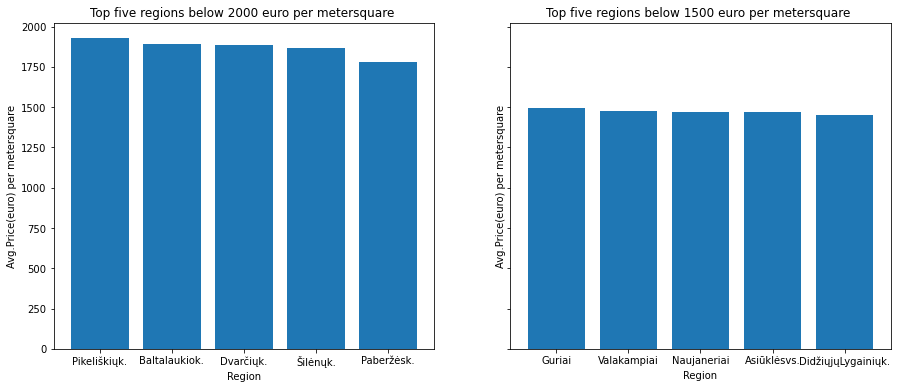

In [57]:
add2 = df['address2']
add3 = df['pricepermeter(euro/m2)']
add2 = pd.Series(add2, name = 'address2', dtype = str)
add3 = pd.Series(add3, name ='regionmeanprice', dtype = float )
df1 = pd.concat([ add2, add3], axis = 1)
regionprice = df1.groupby(['address2'], as_index = False).mean()
regionprice = pd.DataFrame(regionprice)


regionprice1 = regionprice.sort_values(by=['regionmeanprice'], ascending = False)
# by changing the regionmeanprice > 2000 value we control the threshold of above which regions are displayed
df1 = regionprice1.loc[regionprice1['regionmeanprice']<2000,  ['address2', 'regionmeanprice']]
df2 = df1.iloc[:5]

df3 = regionprice1.loc[regionprice1['regionmeanprice']<1500,  ['address2', 'regionmeanprice']]
df4 = df3.iloc[:5]

#fig, ax = plt.subplots(1, 0,figsize=(15, 6))
fig, ax = plt.subplots(1, 2,figsize=(15, 6),  sharey = True)
names = list(df2['address2'])
values = list(df2['regionmeanprice'])

ax[0].bar(names, values, align = 'center')
#plt.xticks(rotation='vertical')

ax[0].set(xlabel='Region', ylabel='Avg.Price(euro) per metersquare' )
ax[0].set_title('Top five regions below 2000 euro per metersquare ')

names = list(df4['address2'])
values = list(df4['regionmeanprice'])

ax[1].bar(names, values, align = 'center')
#plt.xticks(rotation='vertical')
ax[1].set(xlabel='Region', ylabel='Avg.Price(euro) per metersquare' )
ax[1].set_title('Top five regions below 1500 euro per metersquare ')
plt.show()

While calling prospective sellers it would be nice to know how much you can negotiate?! A way around is to know  how old the posting is! Though the site doesnt give this information we can extract this informatio from the URL, the URL has an id for each posting which can give the indication of how old the posting is. Possibly the olders the posting is the more chances of the posting being pricier than what the market accepts and the more chance for negotiation. The id column gives this information. Lets dig out the top oldest postings along with the URL to access the detailed information on the site.

In [58]:
def selectold_id(fromindex, toindex):

    df1 = df.sort_values(by=['id'])
    df2 = df1[['id', 'url']]
    df3 = df2.iloc[fromindex:toindex ]
    return df3

selectold_id(0, 5)

,id,url
1171,10720372,https://www.skelbiu.lt/skelbimai/mediniai-name...
2112,32527897,https://www.skelbiu.lt/skelbimai/parduodamas-k...
2037,34063745,https://www.skelbiu.lt/skelbimai/parduodamas-6...
1076,34374919,https://www.skelbiu.lt/skelbimai/parduodamas-m...
752,35463723,https://www.skelbiu.lt/skelbimai/parduodamas-n...


While we are at it, lets build a Linear Regression model on the data to predict the price. As a first step lets remove the outliers from the data.

In [59]:
df = df[df['price(euro)']<250000]

One hot encoding the category variable for the regression model

In [60]:


df.loc[df['condition']=='Dalinė apdaila','Dalinė apdaila']=1
df.loc[df['condition']=='Dujinis','Dujinis']=1
df.loc[df['condition']=='Kitas','Kitas']=1
df.loc[df['condition']=='Nebaigtas statyti','Nebaigtas statyti']=1
df.loc[df['condition']=='Neįrengtas','Neįrengtas']=1
df.loc[df['condition']=='Pamatai','Pamatai']=1
df.loc[df['condition']=='Įrengtas','Įrengtas']=1

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1824 entries, 0 to 2147
Data columns (total 27 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   ad_city                 1824 non-null   object  
 1   ad_date                 1824 non-null   object  
 2   url                     1824 non-null   object  
 3   heading                 1824 non-null   object  
 4   address                 1824 non-null   object  
 5   information1            1824 non-null   object  
 6   information2(a)         1824 non-null   object  
 7   information3            1824 non-null   object  
 8   information4            1824 non-null   object  
 9   information5            1824 non-null   object  
 10  price(euro)             1824 non-null   float64 
 11  pricepermeter(euro/m2)  1824 non-null   float64 
 12  housearea(m2)           1824 non-null   float64 
 13  id                      1824 non-null   object  
 14  address1                

In [61]:
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from fastai.tabular import *
from sklearn.ensemble import RandomForestRegressor
my_imputer = SimpleImputer()

train_x1 = df.drop(['ad_city','ad_date','url','address','heading','information1','information2(a)' ,'information3','information4', 'information5','price(euro)' , 'id', 'address1','address2','address3', 'condition','pricepermeter(euro/m2)'],axis=1)
train_x = my_imputer.fit_transform(train_x1)
train_y = df['price(euro)']

X,test_x,Y,test_y = train_test_split(train_x, train_y, test_size=0.2)

In [62]:
clf_regression = LinearRegression( normalize = True)
clf_randomforest = RandomForestRegressor(n_jobs = -1)
clf_regression.fit(np.array(X),Y)
clf_randomforest.fit(np.array(X),Y)

RandomForestRegressor(n_jobs=-1)

In [63]:
from sklearn.metrics import mean_squared_error

predictions = clf_regression.predict(test_x)
mse = mean_squared_error(test_y, predictions)
rmse = np.sqrt(mse)
print('Regression rmse', rmse)

predictions = clf_randomforest.predict(test_x)
mse = mean_squared_error(test_y, predictions)
rmse = np.sqrt(mse)
print('Random Forest rmse', rmse)


Regression rmse 50065.4084222946
Random Forest rmse 43480.75013434663


The Random forest model performs better at the prediction than the linear regressor

**Market During the Corona Period**

We took a significant detour in data exploration and running predictive models!. Back to the original question "Did the market go down during the corona period?"

Lets just run a visualisation during the entire period which will give us an overview.

The scrapy scraper was run once in a week to collect the data, the data is uploaded as part of the vilnius data set along with the notebook. We can figure out the mean price of postings and plot them.

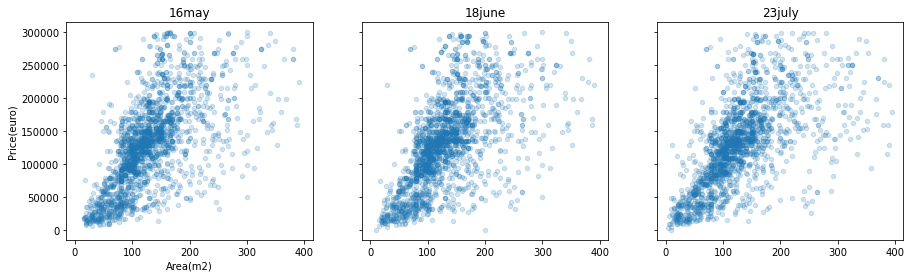

In [64]:

date = ['16may', '28may', '4june', '11june', '18june', '25june', '2july', '9july', '15july', '23july']
path = f"../input/vilnius/{date[3]}.xml"

fig, ax = plt.subplots(1, 3,figsize=(15, 4), sharex = True, sharey = True)

path = f"../input/vilnius/{date[0]}.xml"
df = xml_to_dataframe(path)
df1 = df.loc[df['price(euro)']<300000, ['housearea(m2)', 'price(euro)']]
df2 = df1.loc[df['housearea(m2)']<400, ['housearea(m2)', 'price(euro)']]

ax[0].set_xlabel('Area(m2)')  # Add an x-label to the axes.
ax[0].set_ylabel('Price(euro)')  # Add a y-label to the axes.
ax[0].scatter( df2['housearea(m2)'], df2['price(euro)'], s = 20, alpha = .2)
ax[0].set_title(date[0])

path = f"../input/vilnius/{date[4]}.xml"
df = xml_to_dataframe(path)
df1 = df.loc[df['price(euro)']<300000, ['housearea(m2)', 'price(euro)']]
df2 = df1.loc[df['housearea(m2)']<400, ['housearea(m2)', 'price(euro)']]
ax[1].scatter( df2['housearea(m2)'], df2['price(euro)'], s = 20, alpha = .2)
ax[1].set_title(date[4])

path = f"../input/vilnius/{date[9]}.xml"
df = xml_to_dataframe(path)
df1 = df.loc[df['price(euro)']<300000, ['housearea(m2)', 'price(euro)']]
df2 = df1.loc[df['housearea(m2)']<400, ['housearea(m2)', 'price(euro)']]
ax[2].scatter( df2['housearea(m2)'], df2['price(euro)'], s = 20, alpha = .2)
ax[2].set_title(date[9])

plt.show()


There is movement in the market but the scatter plots dont give a clear idea of what is happening.

One simple way to track the market is to track mean price of postings over the period. 
Lets run the file through the entire dataset and capture the average price (pmean) and the average price per meter square(ppmean)

In [65]:
date = ['16may', '28may', '4june', '11june', '18june', '25june', '2july', '9july', '15july', '23july']
pmean = []
ppmean = []
idcount = []
idmin = []
idmax = []
for i in range(len(date)):
    path = f"../input/vilnius/{date[i]}.xml"
    df = xml_to_dataframe(path)
    ppmean.append(df['pricepermeter(euro/m2)'].mean() )
    pmean.append(df['price(euro)'].mean())
    idcount.append(df['id'].count())
    idmin.append(df['id'].min())
    idmax.append(df['id'].max())
    


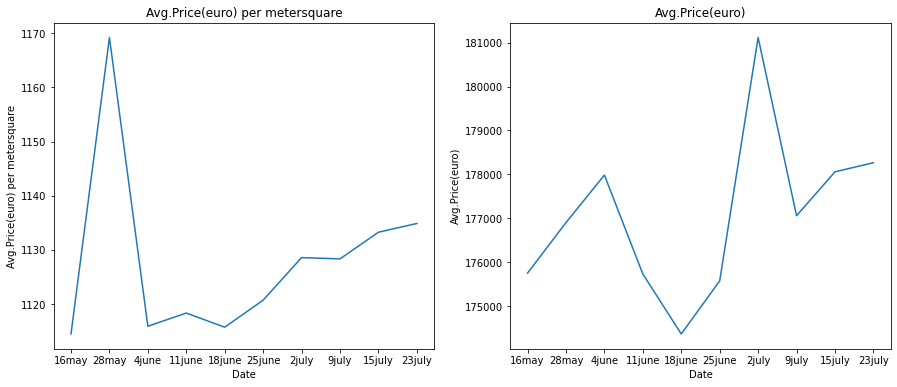

In [66]:
fig, ax = plt.subplots(1, 2,figsize=(15, 6))
ax[0].plot(date, ppmean)
ax[0].set(xlabel='Date', ylabel='Avg.Price(euro) per metersquare' )
ax[0].set_title('Avg.Price(euro) per metersquare')

ax[1].plot(date, pmean)
#plt.xticks(rotation='vertical')
ax[1].set(xlabel='Date', ylabel='Avg.Price(euro)' )
ax[1].set_title('Avg.Price(euro)')

plt.show()

Lets have a quick look at the no of postings before we come to a conclusion.

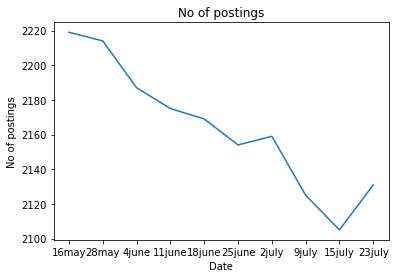

In [67]:
ax = plt.subplot()
ax.plot(date, idcount)
ax.set(xlabel='Date', ylabel='No of postings' )
ax.set_title('No of postings')
plt.show()

**Conclusion**:
The average price actually increased marginally during the period of the study. The no of postings decreased which is quite in keeping with demand and supply. This is quite counterintuitive to what everyone was thinking or assuming. Data truly takes the guesswork out of decisions!

Next Steps:
There are a couple of ideas to take this forward;

1. A real time dashboard app linked to data sources
2. Incorporating images in the prediction model 
3. Creating a data product for real estate agents based on their needs